## Задание

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

2. Оцените ошибку модели из п.2 .

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.
4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :).
    
    б) Количество денег, которые тратят покупатели в интернет магазине.
    
    в) Вес растущего котенка.
    
    г) Прирост объема деревьев в лесу от времени

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

In [2]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

# path_brent = 'my_BRENT2019.csv'
# brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])



In [4]:
data

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02,20:00:00,44057.0,2018,8,2,3,214,31,3,20,0,0,0
2018-08-02,21:00:00,43256.0,2018,8,2,3,214,31,3,21,0,0,0
2018-08-02,22:00:00,41552.0,2018,8,2,3,214,31,3,22,0,0,0


/Users/daniilstv/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


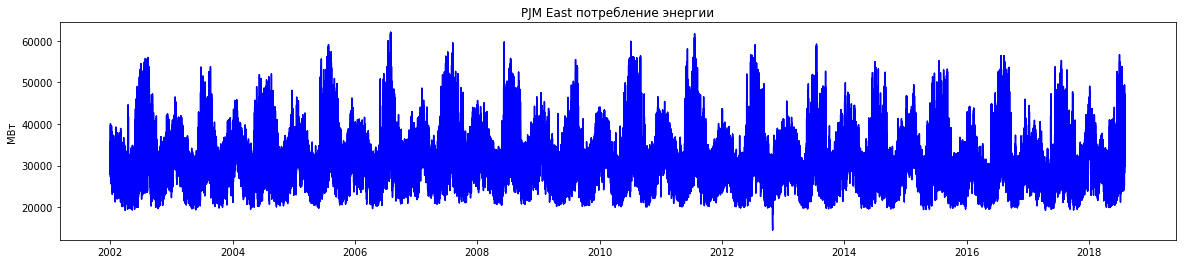

In [5]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

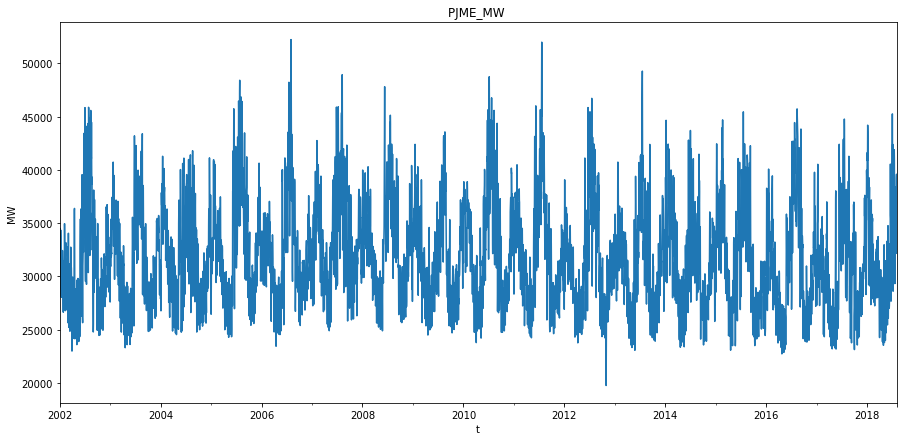

In [6]:
data_d = data.resample('D').mean()
# brent_data_d = brent_data.resample('D').mean()

# _ = brent_data_d['Значение'].plot( style='-', figsize=( 15, 7 ), title='Brent ')
# plt.ylabel('USA dollar')
# plt.xlabel('t')
# plt.show()

_ = data_d['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

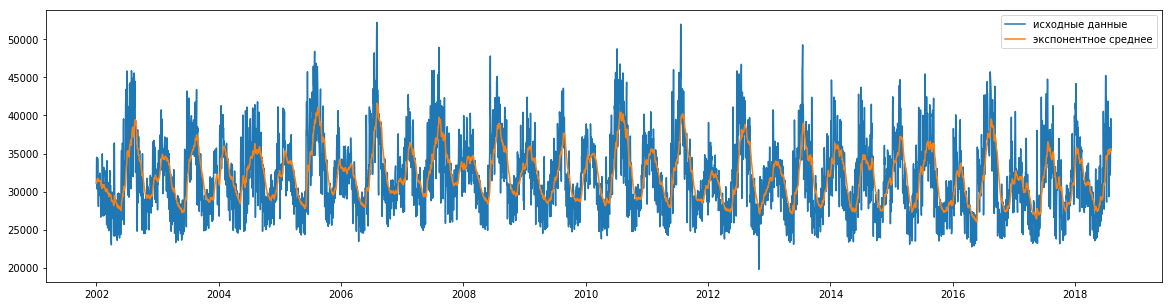

In [7]:
exp_av = exponential_smoothing(data_d['PJME_MW'], 0.05)
df = pd.DataFrame(exp_av, columns=['exp_av'], index=data_d.index)


plt.figure(figsize=(20,5))
plt.plot(data_d.index, data_d['PJME_MW'], label='исходные данные')
plt.plot(df.index, df['exp_av'], label='экспонентное среднее')
plt.legend(loc='upper right')

In [8]:
p = 5

for i in range(1, p+1):
    df[f't{i}'] = 0
    df.iloc[1:, -1] = df.iloc[:-1, -2].values

    
# df['exp_0_01'] = exponential_smoothing(data_d[0], 0.01)
# df['exp_0_03'] = exponential_smoothing(data_d[0], 0.03)
# df['exp_0_08'] = exponential_smoothing(data_d[0], 0.08)

df

,exp_av,t1,t2,t3,t4,t5
Date,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,0.000000,0.000000
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,0.000000,0.000000
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,0.000000,0.000000
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,0.000000,0.000000
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31080.739130,0.000000
...,...,...,...,...,...,...
2018-07-30,35241.910443,35362.146957,35530.527499,35584.989473,35447.804708,35301.838289
2018-07-31,35206.769087,35241.910443,35362.146957,35530.527499,35584.989473,35447.804708
2018-08-01,35407.970216,35206.769087,35241.910443,35362.146957,35530.527499,35584.989473


In [9]:
train, test = split_data_b(df, '2016-08-01')

scaller = StandardScaler()

model_gb = GradientBoostingRegressor(max_depth=10, random_state=42, n_estimators=500)


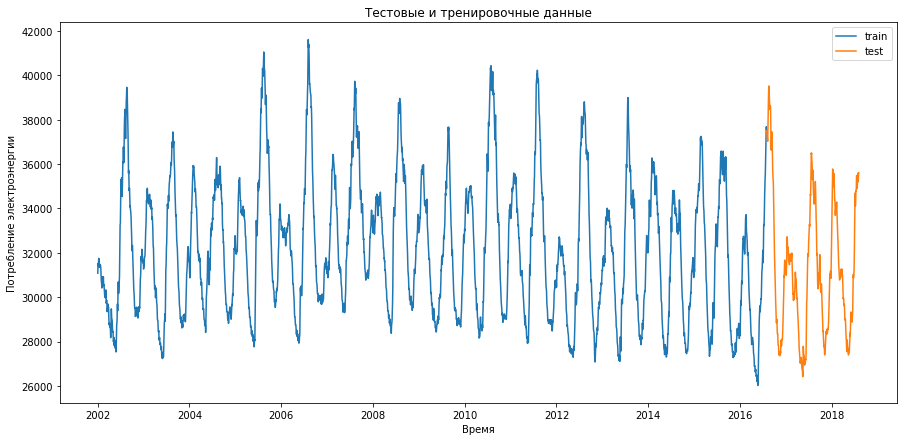

In [10]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление электроэнергии')
plt.plot(train.index.get_level_values('Date'),train[df.columns[0]], label='train' )
plt.plot(test.index.get_level_values('Date'),test[df.columns[0]], label='test')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [11]:
h = 1

X_train_1 = train.iloc[:-h,:]
y_train_1 = train[df.columns[0]].values[h:]
X_test_1 = test.iloc[:-h,:]
y_test_1 = test[df.columns[0]].values[h:]

In [12]:

X_train_1 = scaller.fit_transform(X_train_1)
X_test_1 = scaller.transform(X_test_1)



In [13]:
model_gb.fit(X_train_1, y_train_1) 
X_test_pred_gb = model_gb.predict(X_test_1)

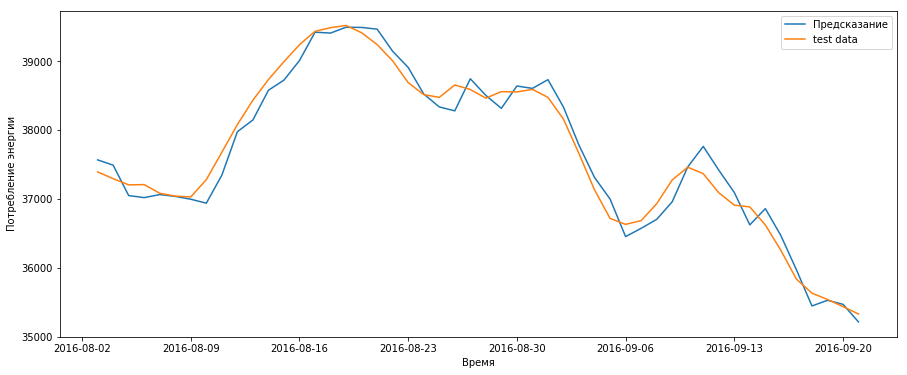

ошибка при h=1:   0.3770004502363032 %


In [14]:
plt.figure( figsize=(15, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test.index[h:h+50], X_test_pred_gb[:50], label='Предсказание')
plt.plot(test.index[h:h+50], y_test_1[:50], label='test data')
#plt.plot(d_data.loc['2017-01-01':].index[h:], d_data.loc['2017-01-01':]['PJME_MW'].values[h:], label='исходный ряд')

plt.legend()
plt.show()

er_g_1 = mean_absolute_percentage_error(y_true=y_test_1, y_pred=X_test_pred_gb)

print('ошибка при h=1:  ', er_g_1, '%')

In [15]:
h = 10

X_train_10 = train.iloc[:-h,:]
y_train_10 = train[df.columns[0]].values[h:]
X_test_10 = test.iloc[:-h,:]
y_test_10 = test[df.columns[0]].values[h:]

In [16]:
X_train_10 = scaller.fit_transform(X_train_10)
X_test_10 = scaller.transform(X_test_10)



In [17]:
model_gb.fit(X_train_10, y_train_10) 
X_test_pred_gb_10 = model_gb.predict(X_test_10)

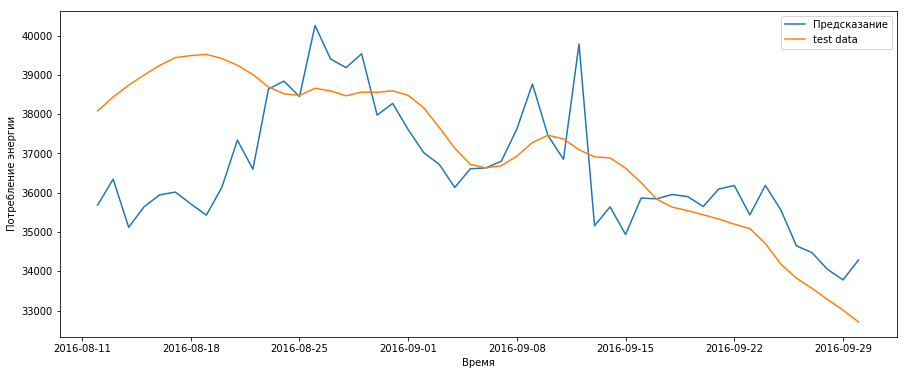

ошибка при h=10:   2.9377449279310603 %


In [18]:
plt.figure( figsize=(15, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test.index[h:h+50], X_test_pred_gb_10[:50], label='Предсказание')
plt.plot(test.index[h:h+50], y_test_10[:50], label='test data')
#plt.plot(d_data.loc['2017-01-01':].index[h:], d_data.loc['2017-01-01':]['PJME_MW'].values[h:], label='исходный ряд')

plt.legend()
plt.show()

er_g_10 = mean_absolute_percentage_error(y_true=y_test_10, y_pred=X_test_pred_gb_10)

print('ошибка при h=10:  ', er_g_10, '%')

In [22]:
x = er_g_10 / er_g_1

In [25]:
print(f"При увеличении горизонта прогноза до 10 ошибка увеличилась в {x.round(1)} раз. Для стационарных процессов снижение качества прогноза менее существенно.")

При увеличении горизонта прогноза до 10 ошибка увеличилась в 7.8 раз. Для стационарных процессов снижение качества прогноза менее существенно.


Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :).
- стационарный в масштабе нескольких лет. Сезонный. Ежегодный и суточный цикл. Без тренда.



б) Количество денег, которые тратят покупатели в интернет магазине
- не стационарный ряд. Есть сезонность и цикличность (зависит от товаров). Тренд растущий.


в) Вес растущего котенка.
- не стационарный с растущим трендом - до превращения котёнка в кота.


г) Прирост объема деревьев в лесу от времени
- не стационарный с растущим трендом, ограниченным ареалом. Сезонность, цикличность - весенний всход семян.